# Data Exploration Notebook
Created in google collab with dirty_data.zip uploaded to the workspace.

# Imports

In [37]:
import pandas as pd
import numpy as np
import datetime
from datetime import datetime
import joblib

from sklearn.model_selection import train_test_split

from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor, BaggingRegressor, AdaBoostRegressor

import matplotlib.pyplot as plt
import seaborn as sns

# Data Cleaning

In [38]:
dirty = pd.read_csv('dirty_data.zip')
dirty.head()

,timestamp,holiday,apparent_temperature,weather_intensity,station_mean,rentals
0,2022-01-01 00:00:00,True,28.265075,0.727375,89,0
1,2022-01-01 00:00:00,True,39.444718,0.707861,28,1
2,2022-01-01 00:00:00,True,30.601002,0.339899,15,0
3,2022-01-01 00:00:00,True,29.157094,0.414309,81,0
4,2022-01-01 00:00:00,True,27.662519,0.668358,47,0


In [39]:
dirty['timestamp'] = dirty["timestamp"].map(lambda p: datetime.strptime(p, '%Y-%m-%d %H:%M:%S'))
dirty.isnull().values.any()

False

In [40]:
cleaned = pd.DataFrame()

cleaned['month'] = dirty['timestamp'].map(lambda p: p.month)
cleaned['weekday'] = dirty['timestamp'].map(lambda p: p.weekday())
cleaned["hour"] = dirty["timestamp"].map(lambda p: p.hour / 23)

cleaned["isWorkday"] = dirty.apply(lambda p: 0 if (p['holiday'] or p['timestamp'].weekday() in [0,6]) else 1, axis='columns')

cleaned['holiday'] = dirty['holiday'].map(lambda p: 1 if p else 0)
cleaned["temp"] = dirty["apparent_temperature"] / 104.0
cleaned["weather"] = dirty['weather_intensity']
cleaned["demand"] = dirty["rentals"] / dirty["station_mean"]

cleaned.head()

,month,weekday,hour,isWorkday,holiday,temp,weather,demand
0,1,5,0.0,0,1,0.271780,0.727375,0.000000
1,1,5,0.0,0,1,0.379276,0.707861,0.035714
2,1,5,0.0,0,1,0.294240,0.339899,0.000000
3,1,5,0.0,0,1,0.280357,0.414309,0.000000
4,1,5,0.0,0,1,0.265986,0.668358,0.000000


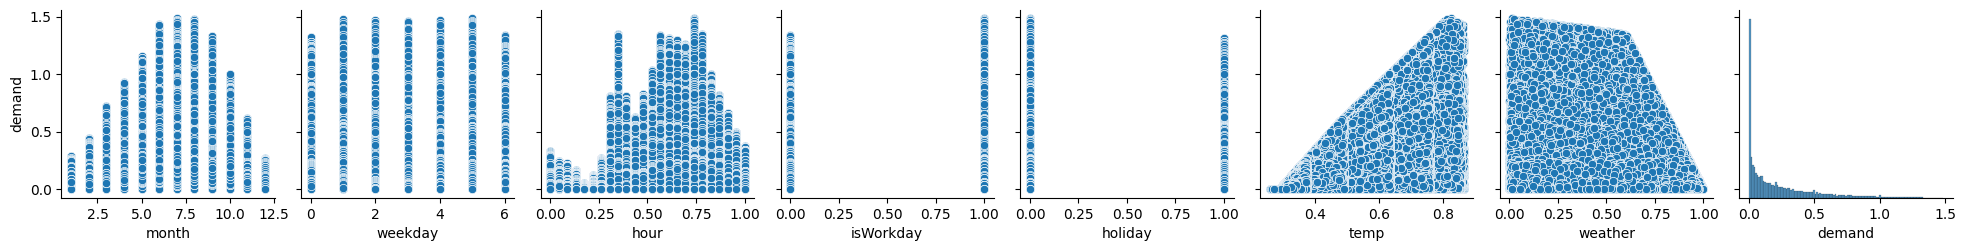

In [42]:
sns.pairplot(cleaned, y_vars=['demand'])
plt.show()

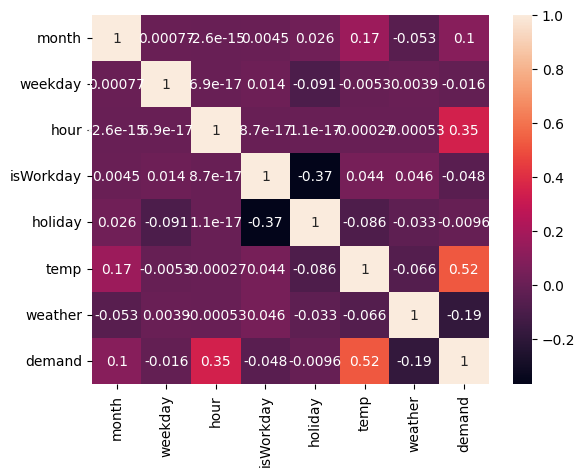

In [55]:
matrix = cleaned.corr()
sns.heatmap(matrix, annot=True)
plt.show()

<Axes: xlabel='month', ylabel='demand'>

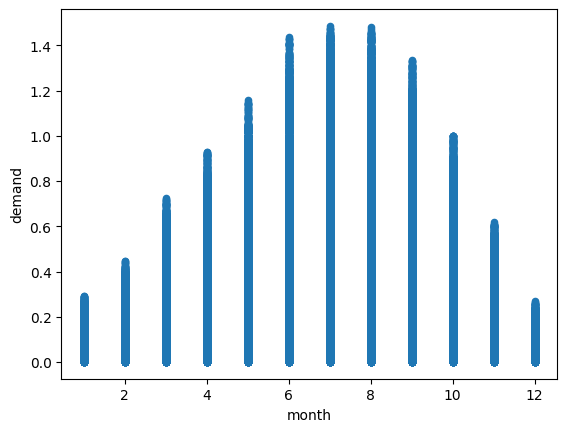

In [44]:
cleaned.plot.scatter(x='month',y='demand')

<Axes: xlabel='month', ylabel='temp'>

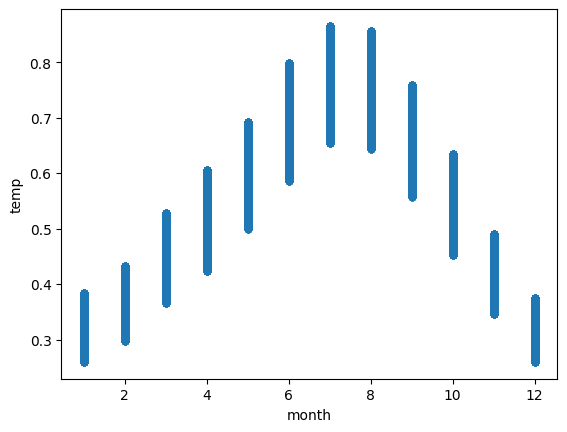

In [45]:
cleaned.plot.scatter(x='month',y='temp')

<Axes: xlabel='hour', ylabel='demand'>

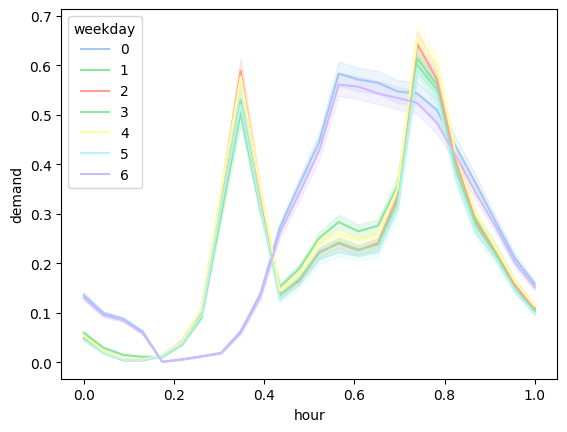

In [46]:
sns.lineplot(data=cleaned, x='hour', y='demand', hue='weekday', palette=['#a1c9f4', '#8de5a1', '#ff9f9b', '#8de8a8' , '#fffea3', '#b9f2f0','#d0bbff'])

<Axes: xlabel='hour', ylabel='demand'>

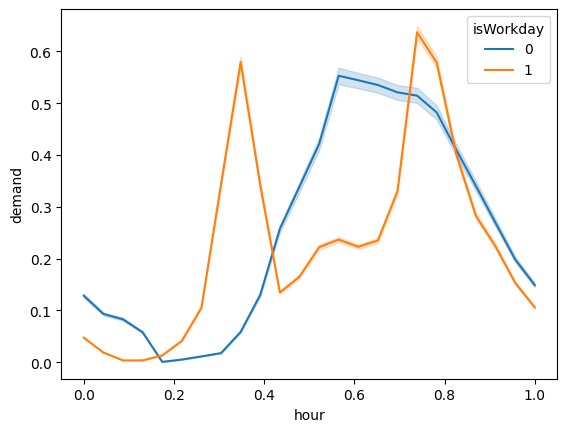

In [54]:
sns.lineplot(data=cleaned, x='hour', y='demand', hue='isWorkday')

# Model Generation and Comparison

In [47]:
final = cleaned.drop(columns=['month','holiday','weekday'])
final.describe()

,hour,isWorkday,temp,weather,demand
count,175200.000000,175200.000000,175200.000000,175200.000000,175200.000000
mean,0.500000,0.668493,0.533026,0.475233,0.235732
std,0.300965,0.470756,0.162189,0.280228,0.282211
min,0.000000,0.000000,0.259623,0.000004,0.000000
25%,0.250000,0.000000,0.384208,0.234110,0.021739
50%,0.500000,1.000000,0.523764,0.469464,0.128205
75%,0.750000,1.000000,0.669292,0.703472,0.350000
max,1.000000,1.000000,0.865376,0.999988,1.486486


In [48]:
X = final.drop(columns=['demand'])
y = final[['demand']].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=41)

In [49]:
models = [XGBRegressor(), KNeighborsRegressor(),  BaggingRegressor(), ExtraTreesRegressor(), RandomForestRegressor()]

mae = []

for model in models:
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  mae.append(mean_absolute_error(y_test, y_pred))


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_bagging.py:508: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True)
<ipython-input-49-1117df409d0a>:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)
<ipython-input-49-1117df409d0a>:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)


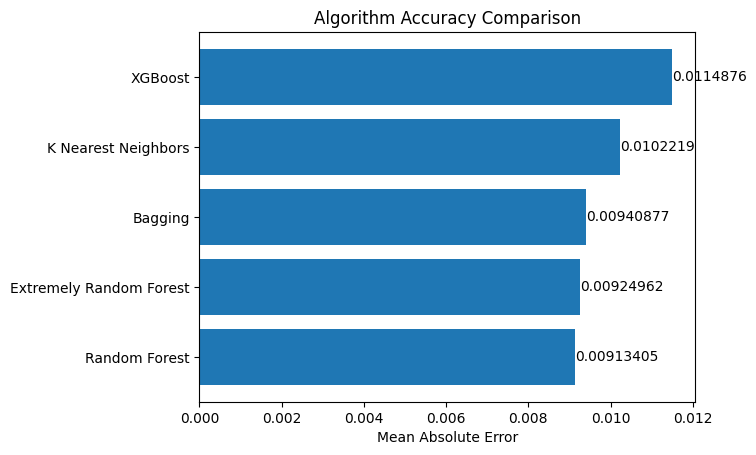

In [50]:
labels = ['XGBoost', 'K Nearest Neighbors','Bagging','Extremely Random Forest', 'Random Forest']

y_pos = np.arange(5)
fig, ax = plt.subplots()
hbars = ax.barh(y_pos, mae, align='center')
ax.set_yticks(y_pos, labels=labels)
ax.invert_yaxis()
ax.set_xlabel('Mean Absolute Error')
ax.set_title('Algorithm Accuracy Comparison')

ax.bar_label(hbars)
plt.show()

# Cleaned Data Export

In [52]:
compression_opts = dict(method='zip', archive_name='clean_data.csv')
cleaned.to_csv('clean_data.zip', index=False, compression=compression_opts)

reimport = pd.read_csv('clean_data.zip')
reimport

,month,weekday,hour,isWorkday,holiday,temp,weather,demand
0,1,5,0.0,0,1,0.271780,0.727375,0.000000
1,1,5,0.0,0,1,0.379276,0.707861,0.035714
2,1,5,0.0,0,1,0.294240,0.339899,0.000000
3,1,5,0.0,0,1,0.280357,0.414309,0.000000
4,1,5,0.0,0,1,0.265986,0.668358,0.000000
...,...,...,...,...,...,...,...,...
175195,12,5,1.0,0,1,0.332999,0.568563,0.000000
175196,12,5,1.0,0,1,0.294664,0.056771,0.000000
175197,12,5,1.0,0,1,0.327222,0.255818,0.016393
175198,12,5,1.0,0,1,0.271709,0.198365,0.000000
